In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import qnmfits
import analytic_fit
import utils
import corner

from cmcrameri import cm
from scipy.interpolate import CubicSpline

plt.rcParams.update(utils.rcparams)

In [2]:
t0_M = pd.read_csv('/Users/rikercoleman/Desktop/LIGOSURF24/overtone-fits/notebooks/data/t0_data_30_to_100.csv', index_col=0)
t0_E = pd.read_csv('/Users/rikercoleman/Desktop/LIGOSURF24/overtone-fits/notebooks/data/t0N_E.csv', index_col=0)

In [3]:
N = 12
modes = [(2, 2, n, 1) for n in range(N+1)]

injection_info, C, omega = utils.injection(
    ID = 1,
    N = N,
    tref=t0_M['1'].values[N],
    returnC=True
)
sim = injection_info['sim']

In [4]:
injection_info_with_320, C_with_320, omega_with_320 = utils.injection(
    ID = 1,
    N = N,
    additional_modes=[(3,2,0,1)],
    tref=t0_M['1'].values[N],
    returnC=True
)
sim_with_320 = injection_info_with_320['sim']

In [5]:
data = {
    'plus': np.real(sim.h[2,2]),
    'cross': -np.imag(sim.h[2,2]),
}

In [6]:
A220_with_320 = np.abs(C_with_320)[0]
A220 = np.abs(C)[0]
A320 = np.abs(C_with_320)[-1]

In [7]:
A220, A220_with_320, A320

(1.579834520366311, 1.5801245323133934, 0.003191897545161376)

In [8]:
omega_220 = omega[0]
tau_220 = -1/np.imag(omega_220)
A220_of_t = A220 * np.exp(-(sim.times-t0_M['1'].values[N])/tau_220)

omega_320 = omega_with_320[-1]
tau_320 = -1/np.imag(omega_320)
A320_of_t = A320 * np.exp(-(sim_with_320.times-t0_M['1'].values[N])/tau_320)

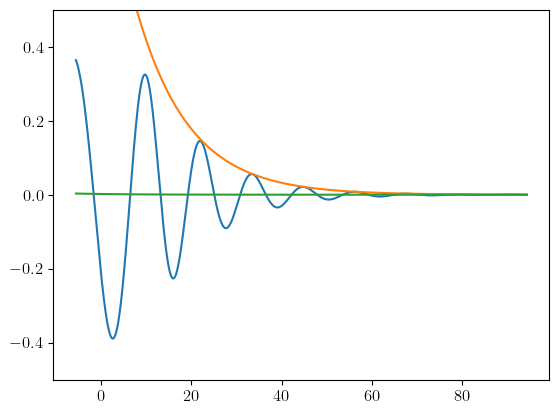

In [9]:
fig, ax = plt.subplots()
# ax.set_yscale('log')

ax.plot(sim.times, np.real(sim.h[2,2]))
ax.plot(sim.times, A220_of_t)
ax.plot(sim.times, A320_of_t)

ax.set_ylim(-0.5, 0.5);

In [10]:
samples, A_samples, phi_samples = analytic_fit.sample(
    times=sim.times,
    data=data,
    # sigma=A320_of_t,
    sigma=A320*np.ones_like(sim.times),
    qnm_omegas=omega,
    t0=t0_M['1'].values[N],
    t0_method='closest',
    T=70,
    reweight=False,
    # n_samples=2000000,
)

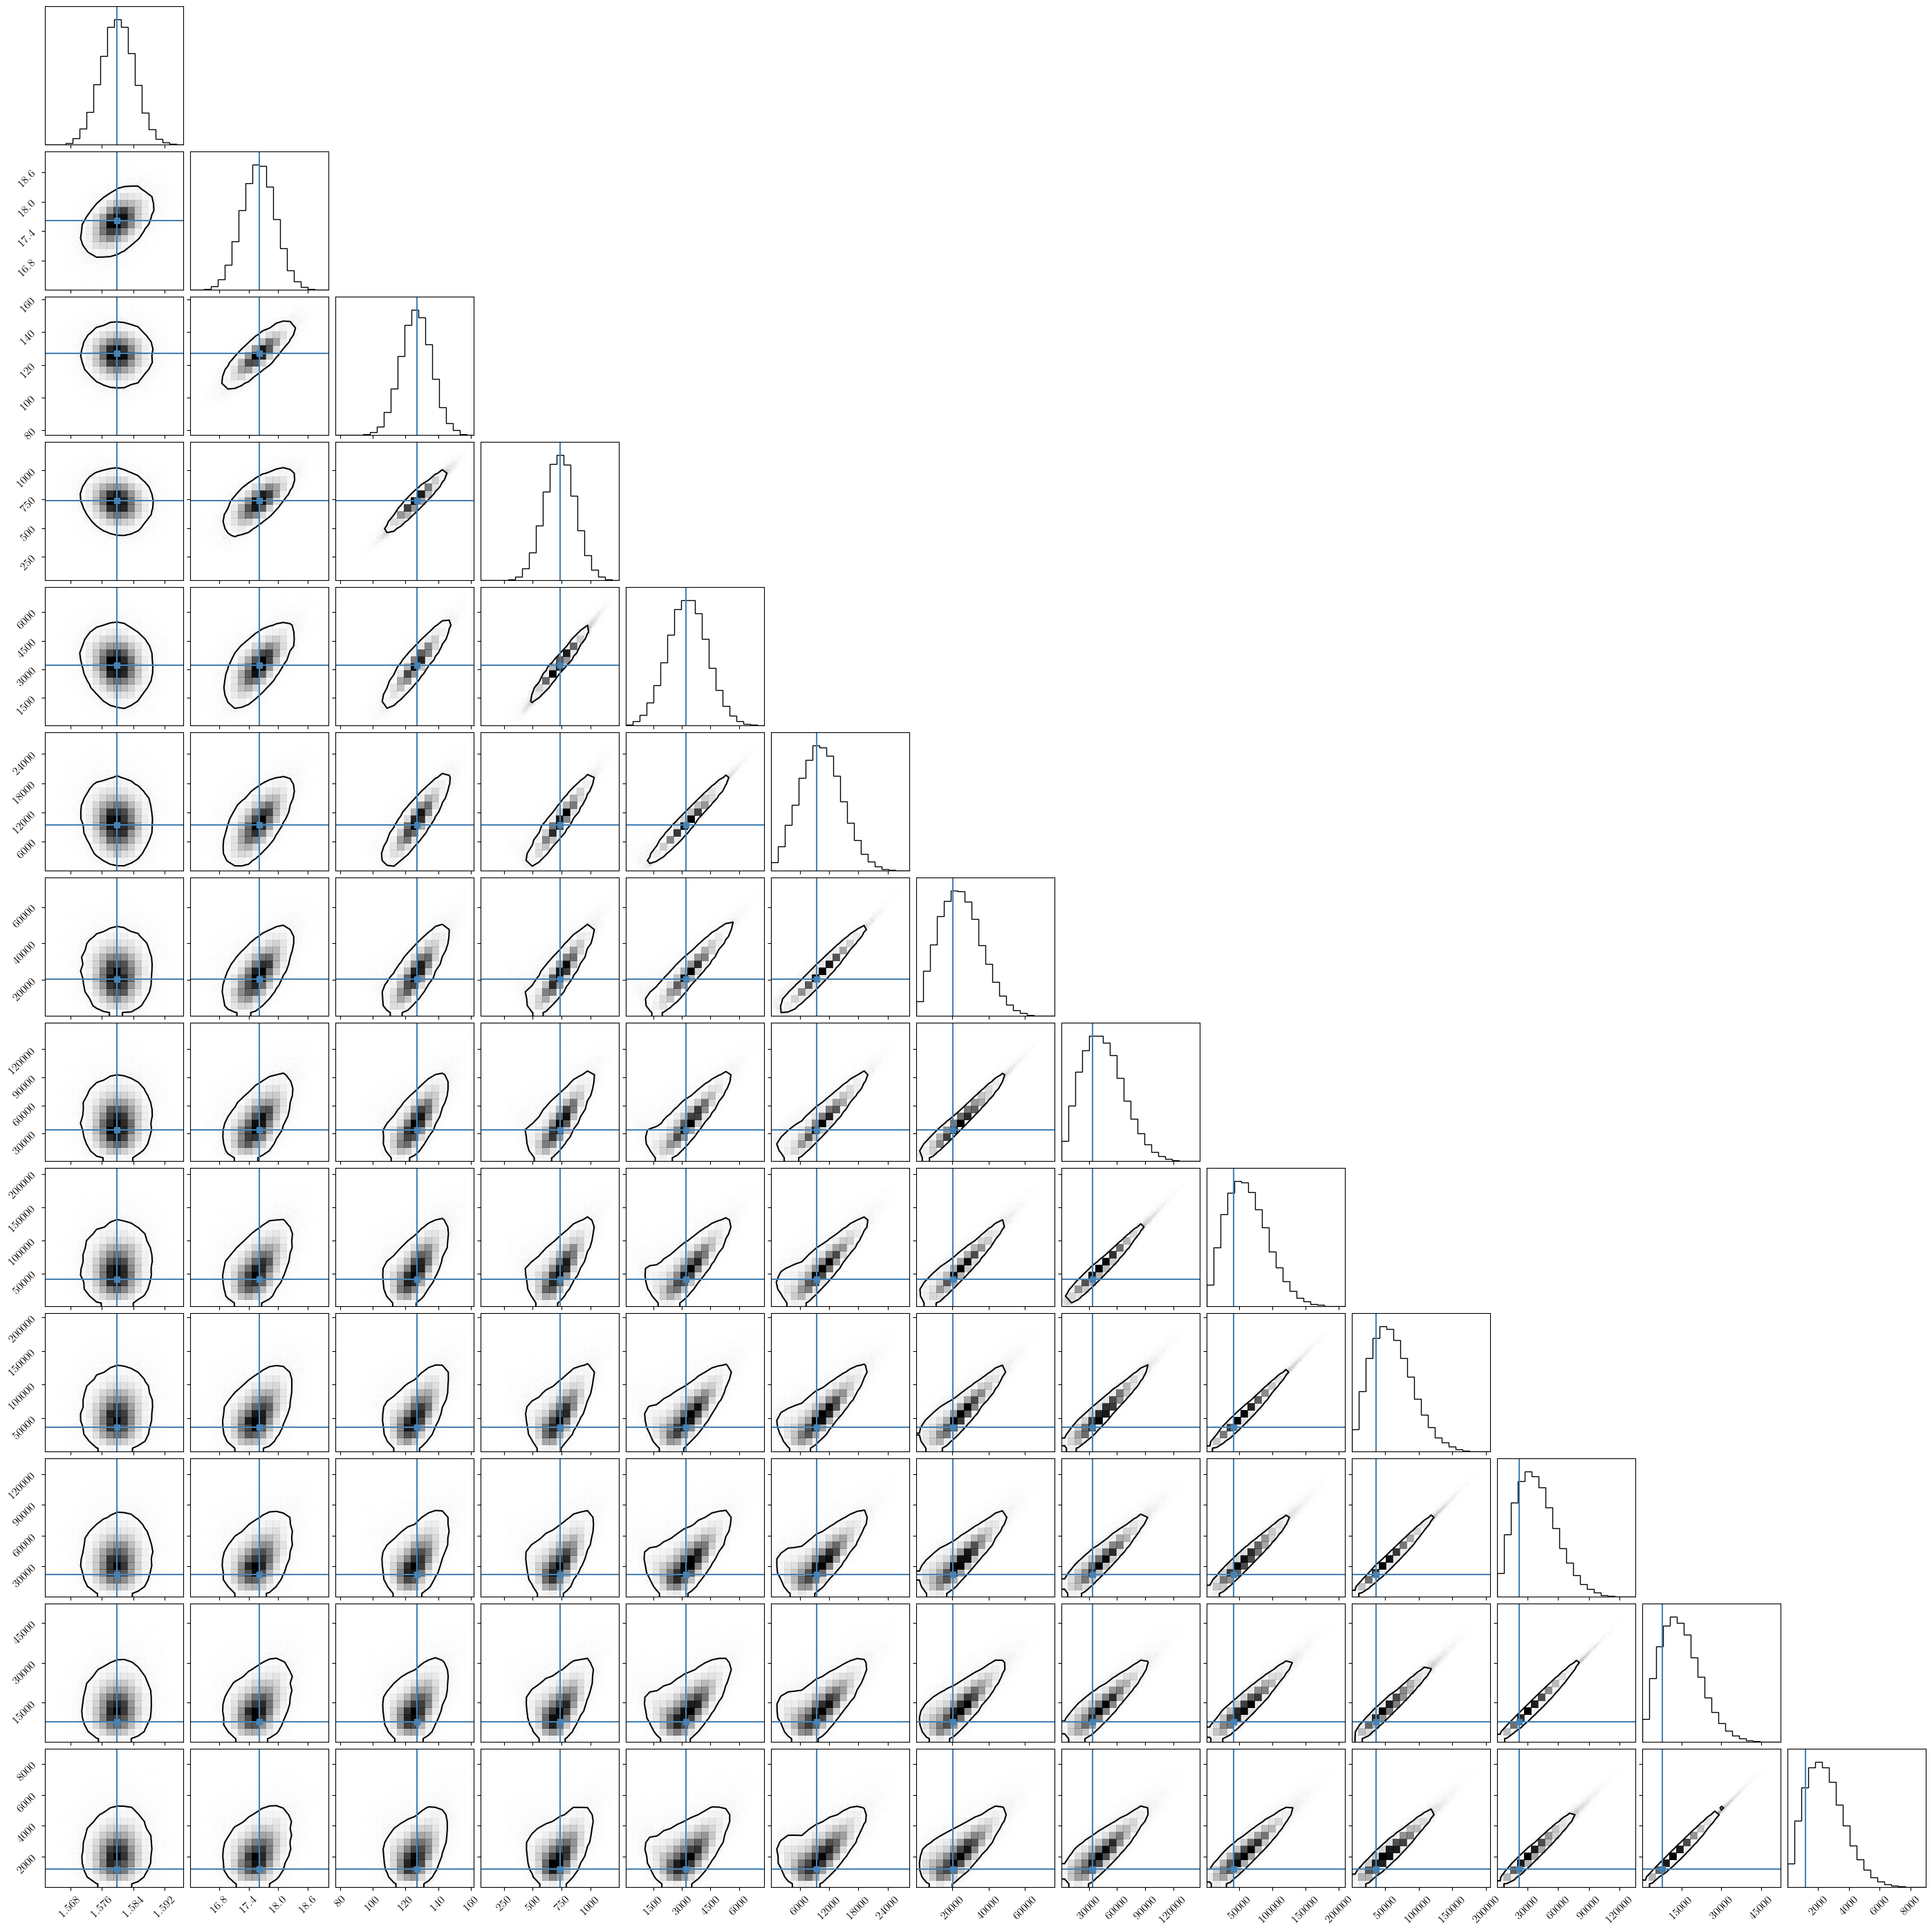

In [11]:
corner.corner(
    A_samples,
    truths=list(np.abs(C)),
    levels=[0.9],
    data_kwargs={
        'alpha': 0.005,
    }
);

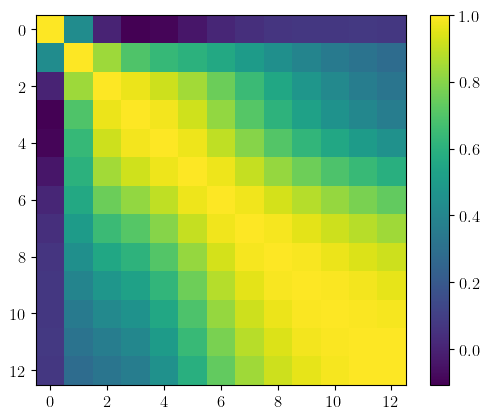

In [12]:
corr_matrix = np.corrcoef(A_samples.T)

fig, ax = plt.subplots()
ax.imshow(corr_matrix)
cbar = plt.colorbar(ax.images[0], ax=ax)

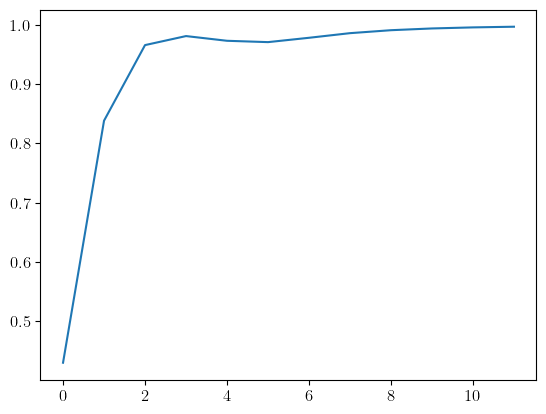

In [13]:
# Take the diagonal below the main diagonal of the correlation matrix
corrs = np.diag(corr_matrix, k=-1)
plt.plot(corrs)

In [14]:

unwrapped_phi_samples = phi_samples.copy()
for i in range(unwrapped_phi_samples.shape[1]):
    unwrapped_phi_samples[:,i] = analytic_fit.unwrap(unwrapped_phi_samples[:,i])


shift = unwrapped_phi_samples[0]-phi_samples[0] 
print(shift) # check that these are the same samples just shifted (all values should be multiples of 2pi)

[-6.28318531 -6.28318531 -6.28318531 -6.28318531  0.          0.
 -6.28318531  0.         -6.28318531  0.         -6.28318531  0.
 -6.28318531]


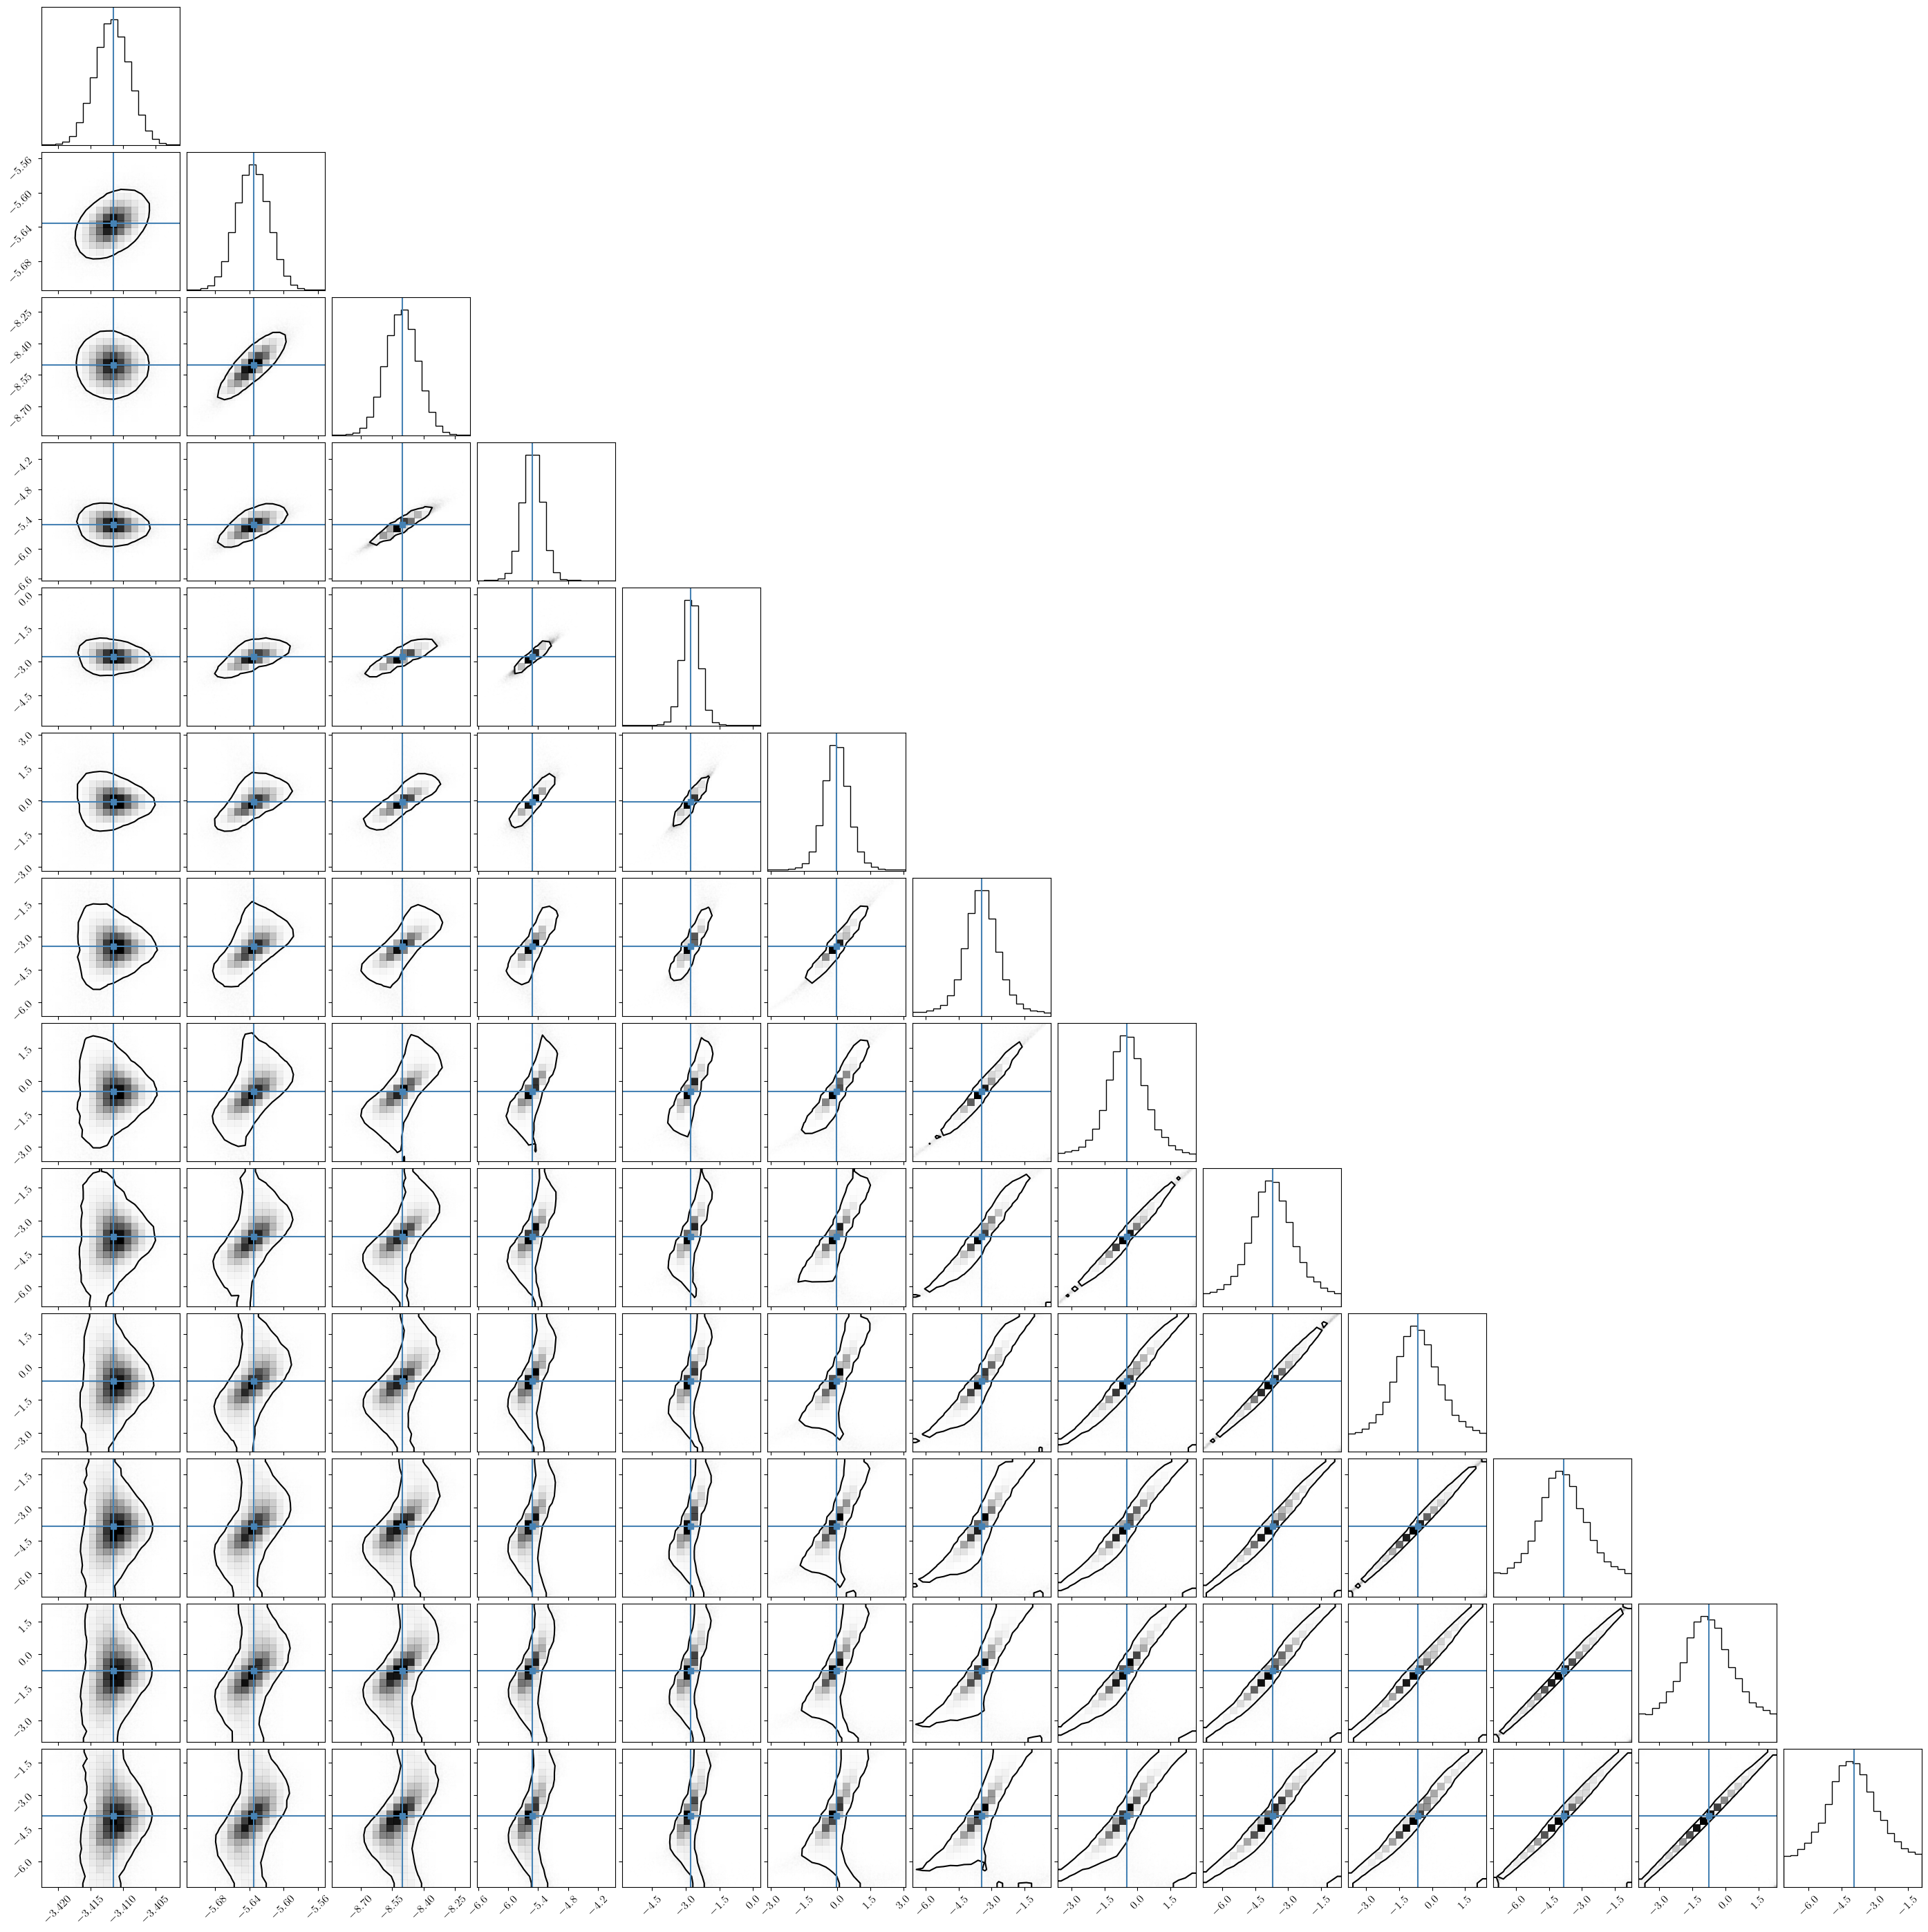

In [15]:
corner.corner(
    unwrapped_phi_samples,
    truths=list(np.angle(C)+shift),
    levels=[0.9],
    data_kwargs={
        'alpha': 0.005,
    }
);

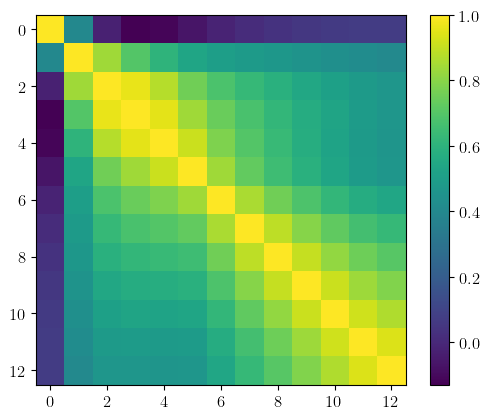

In [16]:
corr_matrix = np.corrcoef(unwrapped_phi_samples.T)

fig, ax = plt.subplots()
ax.imshow(corr_matrix)
cbar = plt.colorbar(ax.images[0], ax=ax)

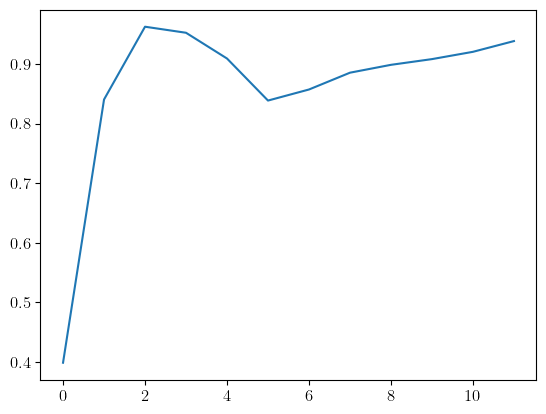

In [17]:
# Take the diagonal below the main diagonal of the correlation matrix
corrs = np.diag(corr_matrix, k=-1)
plt.plot(corrs)

In [18]:
data_with_320 = {
    'plus': np.real(sim_with_320.h[2,2]),
    'cross': -np.imag(sim_with_320.h[2,2]),
}

In [19]:
samples, A_samples_with_320, phi_samples = analytic_fit.sample(
    times=sim.times,
    data=data_with_320,
    # sigma=5*A320_of_t,
    sigma=A320*np.ones_like(sim.times),
    qnm_omegas=omega,
    t0=t0_M['1'].values[N],
    t0_method='closest',
    T=70,
    reweight=False,
    # n_samples=2000000,
)

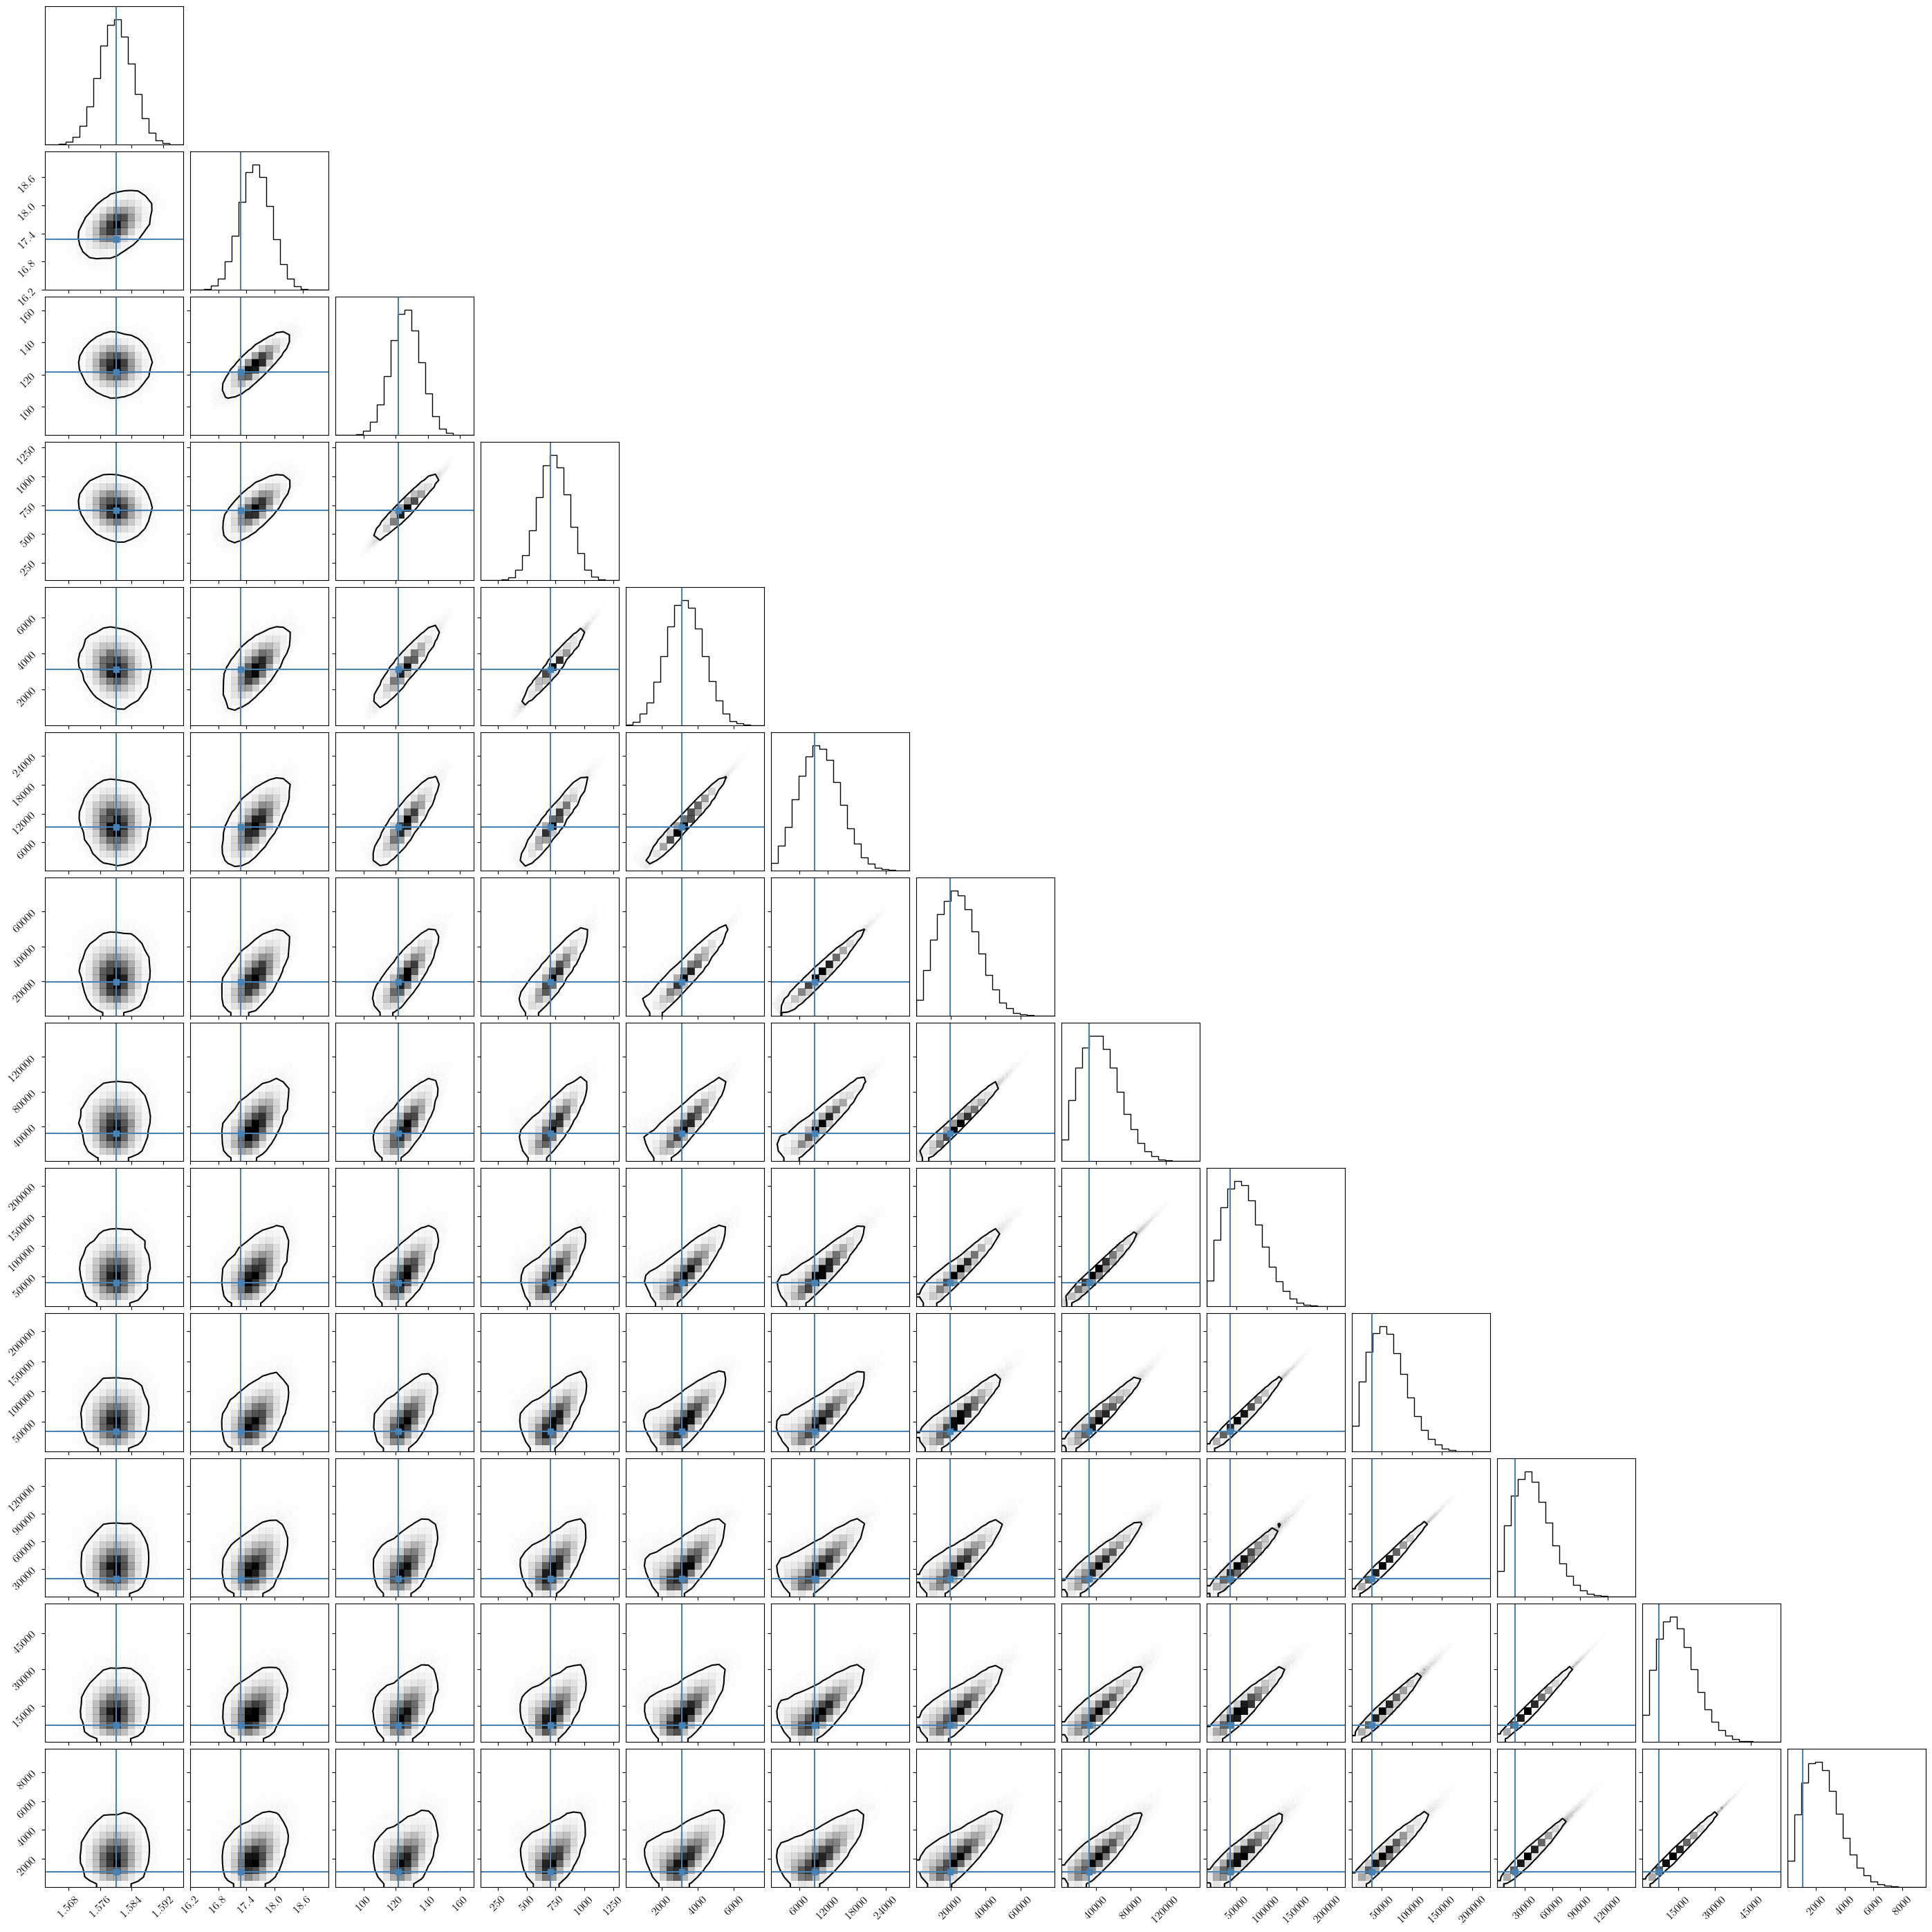

In [20]:
corner.corner(
    A_samples_with_320,
    truths=list(np.abs(C_with_320))[:-1],
    levels=[0.9],
    data_kwargs={
        'alpha': 0.005,
    }
);

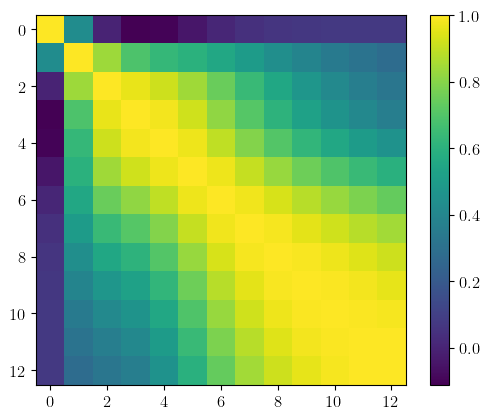

In [21]:
corr_matrix = np.corrcoef(A_samples_with_320.T)

fig, ax = plt.subplots()
ax.imshow(corr_matrix)
cbar = plt.colorbar(ax.images[0], ax=ax)

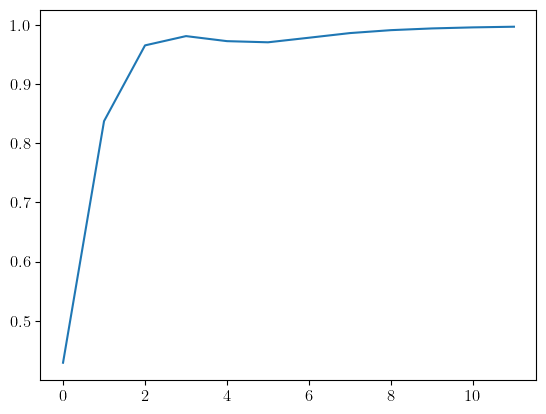

In [22]:
# Take the diagonal below the main diagonal of the correlation matrix
corrs = np.diag(corr_matrix, k=-1)
plt.plot(corrs)

In [23]:
sim_info = utils.load_cce_data(1)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

In [24]:
N = 12
t0 = t0_M['1'].values[N]
modes = [(2, 2, n, 1) for n in range(N+1)] + [(3,2,0,1)]

In [25]:
best_fit = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    modes=modes,
    Mf=Mf,
    chif=chif,
    t0=t0,
    t0_method='closest'
)

In [26]:
best_fit_without_320 = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    modes=[(2, 2, n, 1) for n in range(N+1)],
    Mf=Mf,
    chif=chif,
    t0=t0,
    t0_method='closest'
)

In [27]:
data = {
    'plus': np.real(sim.h[2,2]),
    'cross': -np.imag(sim.h[2,2]),
}

In [28]:
A320 = np.abs(best_fit['C'])[-1]
omega = best_fit['frequencies'][:-1]

In [29]:
samples, A_samples, phi_samples = analytic_fit.sample(
    times=sim.times,
    data=data,
    # sigma=A320_of_t,
    sigma=A320*np.ones_like(sim.times),
    qnm_omegas=omega,
    t0=t0_M['1'].values[N],
    t0_method='closest',
    T=70,
    reweight=False,
    # n_samples=2000000,
)

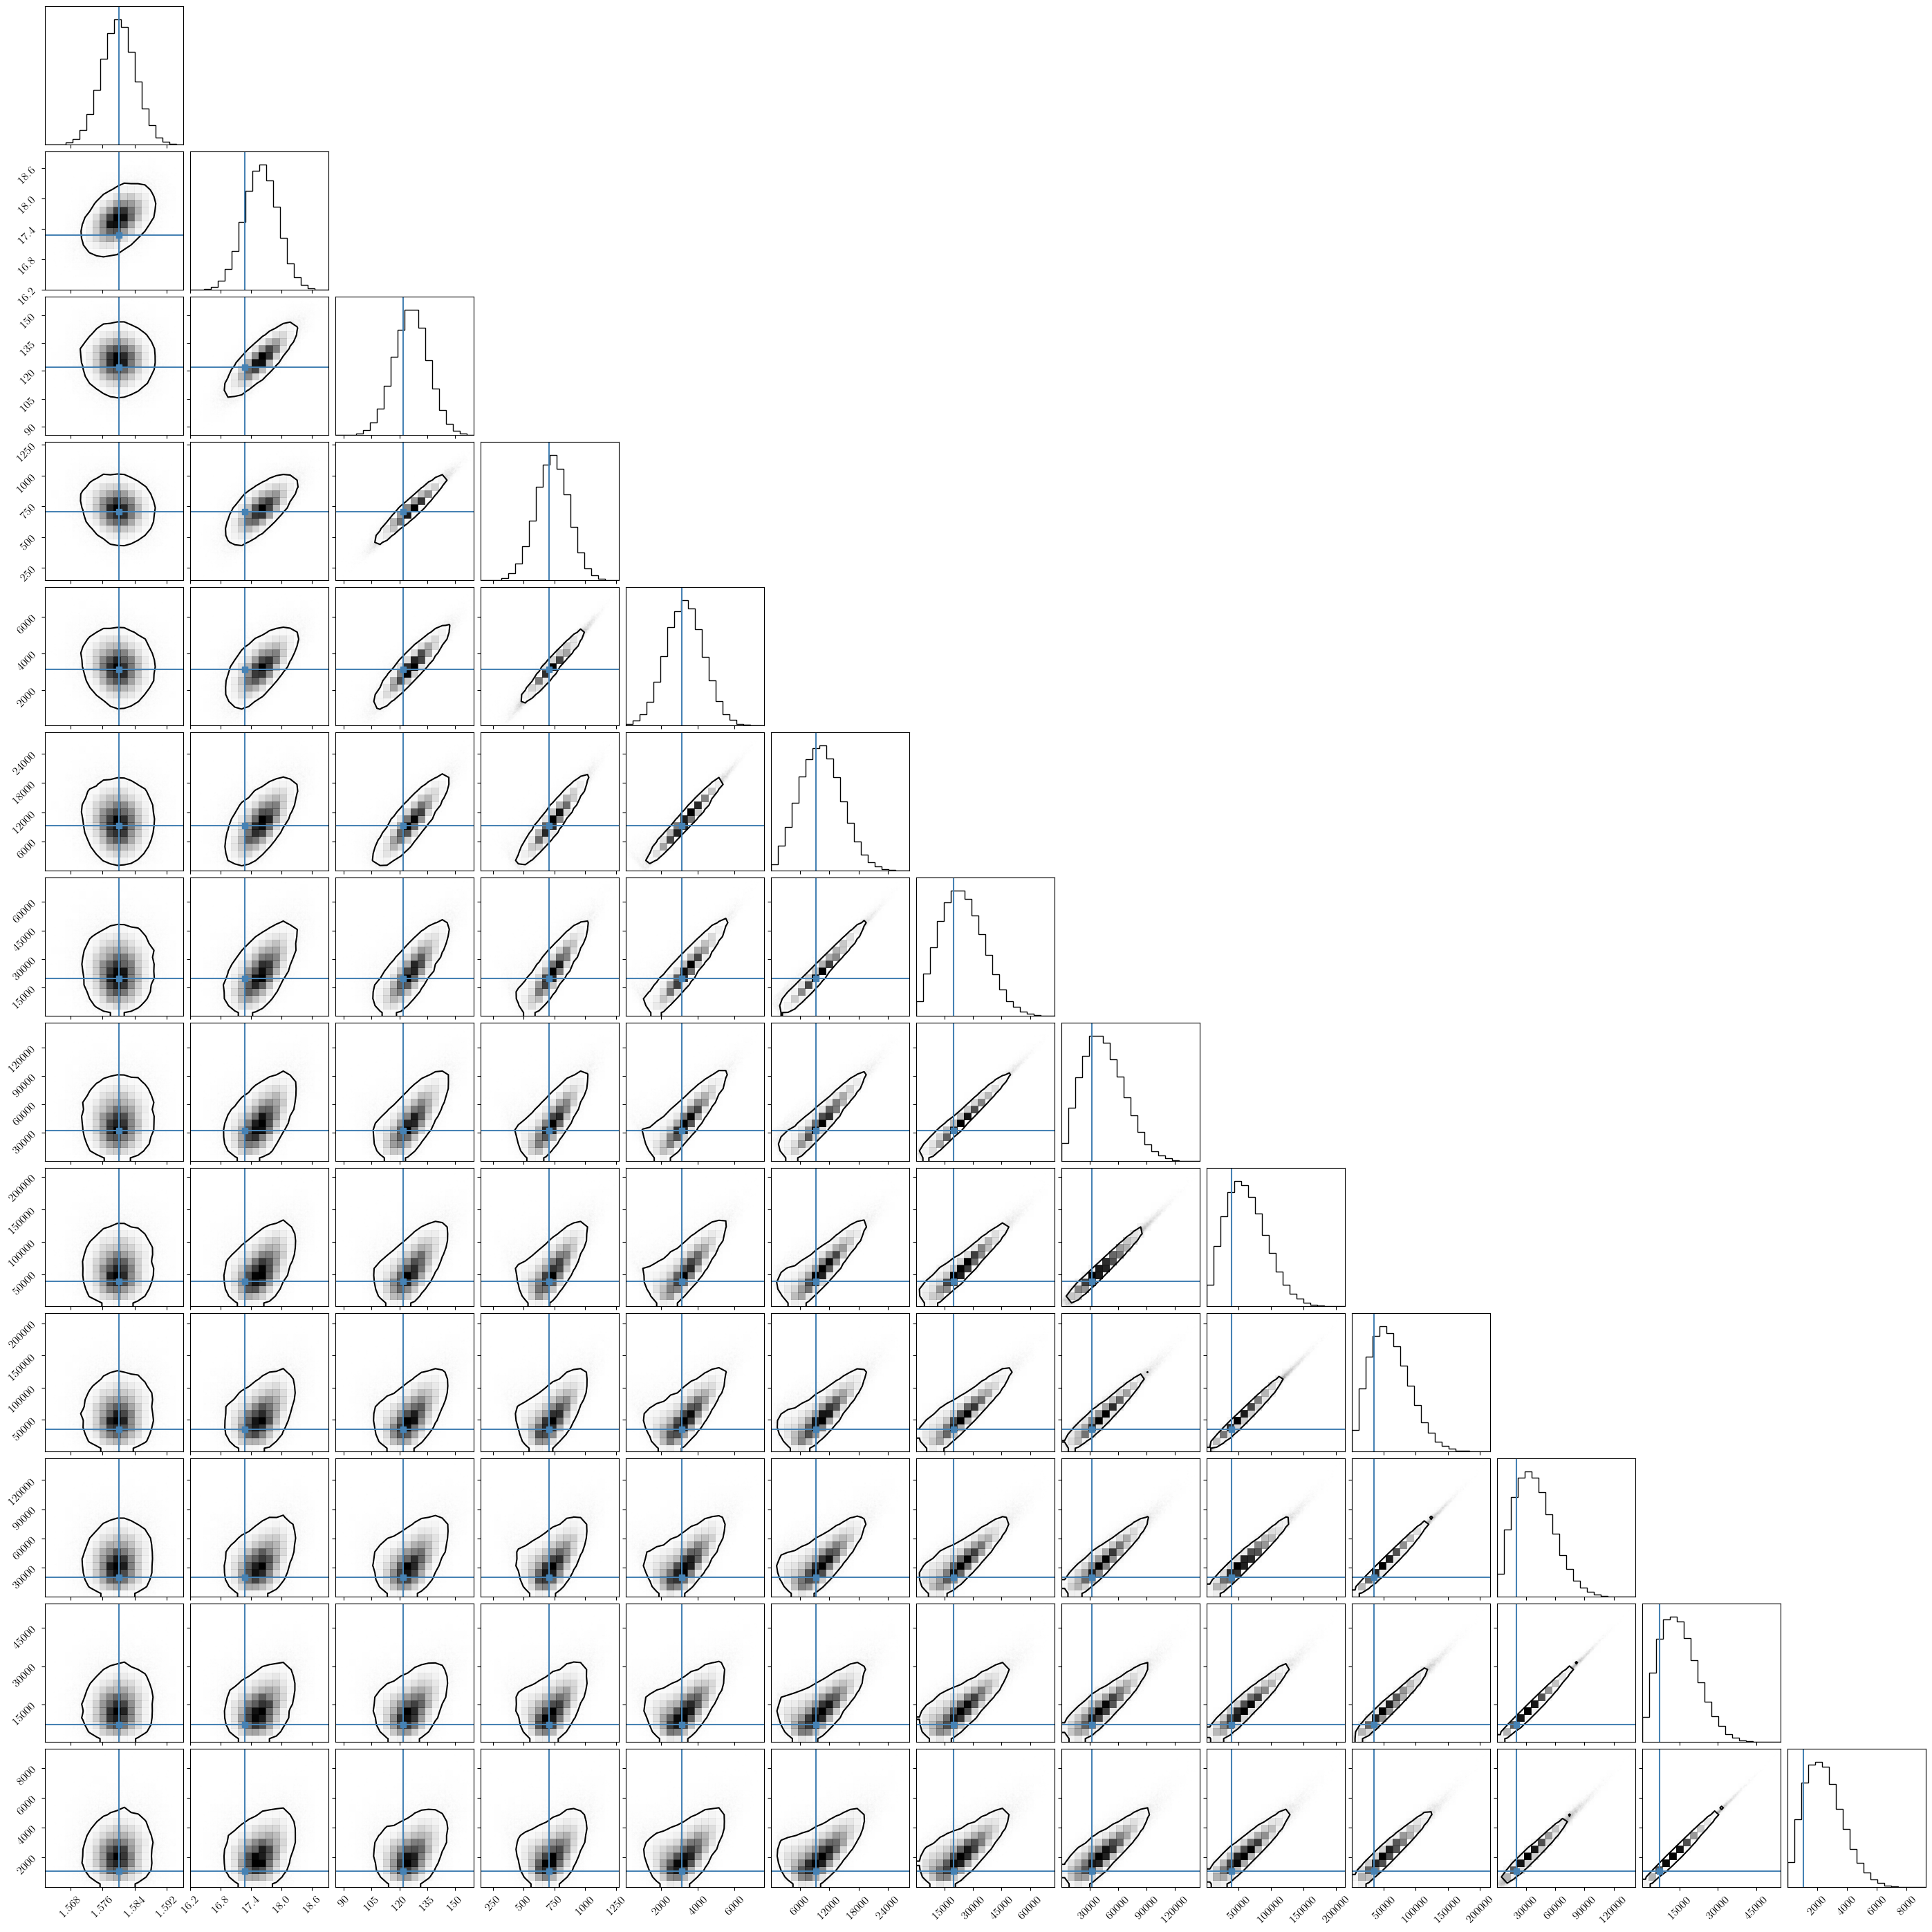

In [30]:
corner.corner(
    A_samples,
    truths=list(np.abs(best_fit['C']))[:-1],
    levels=[0.9],
    data_kwargs={
        'alpha': 0.005,
    }
);

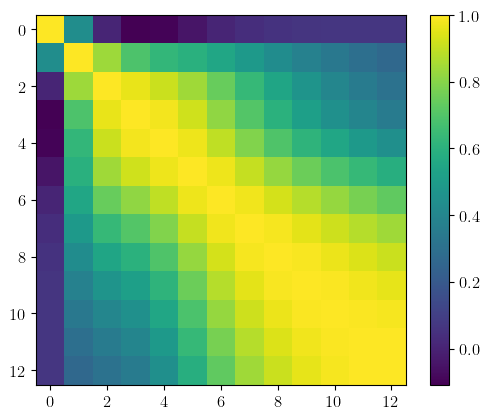

In [31]:
corr_matrix = np.corrcoef(A_samples.T)

fig, ax = plt.subplots()
ax.imshow(corr_matrix)
cbar = plt.colorbar(ax.images[0], ax=ax)

Text(0, 0.5, 'Mode label, $(2,2,n)$')

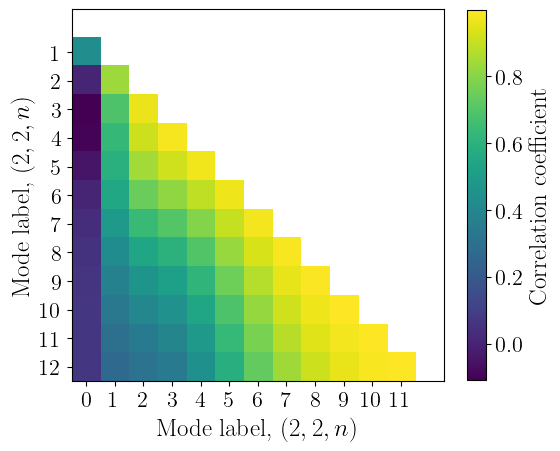

In [32]:
fig, ax = plt.subplots(figsize=(6,6))

masked_matrix = np.ma.masked_array(
    corr_matrix, mask=np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)
)

im = ax.imshow(masked_matrix, cmap='viridis')
cbar = fig.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Correlation coefficient', fontsize=18)
cbar.ax.tick_params(labelsize=16)

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax.tick_params(axis='x', labelsize=16)

ax.set_yticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
ax.tick_params(axis='y', labelsize=16)

ax.set_xlabel('Mode label, $(2,2,n)$', fontsize=18)
ax.set_ylabel('Mode label, $(2,2,n)$', fontsize=18)


# fig.savefig('figures/presentation/correlation_matrix.png', dpi=300, bbox_inches='tight')


Text(0, 0.5, 'Correlation between $n$ and $n+1$')

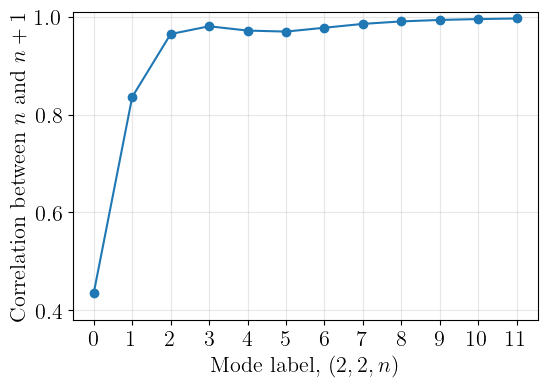

In [33]:
# Take the diagonal below the main diagonal of the correlation matrix
corrs = np.diag(corr_matrix, k=-1)

fig, ax = plt.subplots(figsize=(6, 4))

ax.grid(alpha=0.3)

ax.plot(corrs, marker='o', linestyle='-', color='C0')

ax.set_xticks(range(len(corrs)))
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.set_ylim(0.38, 1.01)

ax.set_xlabel('Mode label, $(2,2,n)$', fontsize=16)
ax.set_ylabel('Correlation between $n$ and $n+1$', fontsize=16)

# fig.savefig('figures/presentation/correlation_diagonal.png', dpi=300, bbox_inches='tight')

[Text(0, 0.4, ''),
 Text(0, 0.5, ''),
 Text(0, 0.6000000000000001, ''),
 Text(0, 0.7000000000000001, ''),
 Text(0, 0.8, ''),
 Text(0, 0.9, ''),
 Text(0, 1.0, '')]

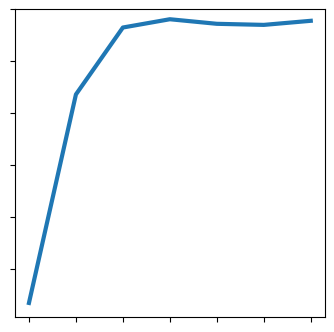

In [34]:
# Take the diagonal below the main diagonal of the correlation matrix
corrs = np.diag(corr_matrix, k=-1)

fig, ax = plt.subplots(figsize=(4, 4))

# ax.grid(alpha=0.3)

ax.plot(corrs[:7], color='C0', lw=3)
# ax.plot(corrs, marker='o', lw=0, color='C0')

# ax.set_xticks(range(len(corrs)))
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

ax.set_ylim(ax.get_ylim()[0], 1.)

# ax.set_xlabel('Mode label, $(2,2,n)$', fontsize=16)
# ax.set_ylabel('Correlation between $n$ and $n+1$', fontsize=16)

ax.set_xticks(np.arange(0, 7))

ax.set_xticklabels([])
ax.set_yticklabels([])

# fig.savefig('figures/presentation/correlation_diagonal_overview.png', dpi=300, bbox_inches='tight')

In [35]:
from matplotlib import colormaps
cmap = colormaps['Blues']

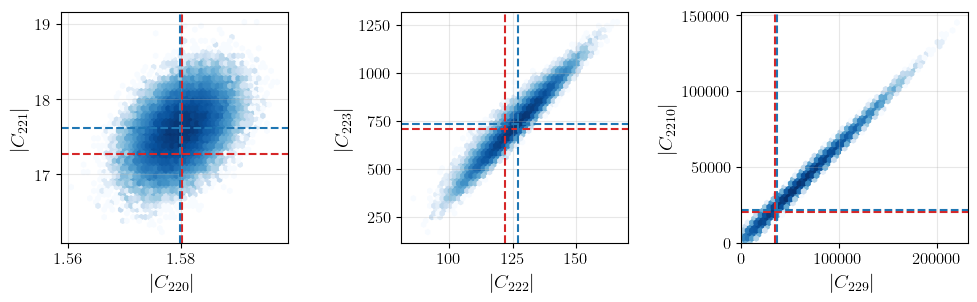

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(11.7, 3))

fig.subplots_adjust(wspace=0.5)

for ax in axs:
    ax.grid(alpha=0.3)

for i, (ni, nj) in enumerate([(0, 1), (2, 3), (9, 10)]):

    x = A_samples[:, ni]
    y = A_samples[:, nj]

    ax = axs[i]
    hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, bins='log')

    ax.axvline(np.abs(best_fit['C'][ni]), color='C3', linestyle='--')
    ax.axhline(np.abs(best_fit['C'][nj]), color='C3', linestyle='--')

    ax.axvline(np.abs(best_fit_without_320['C'][ni]), color='C0', linestyle='--')
    ax.axhline(np.abs(best_fit_without_320['C'][nj]), color='C0', linestyle='--')

    ax.set_xlabel(f'$|C_{{22{ni}}}|$')
    ax.set_ylabel(f'$|C_{{22{nj}}}|$')

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    if xlim[0] < 0:
        ax.set_xlim(0, xlim[1])
    if ylim[0] < 0:
        ax.set_ylim(0, ylim[1])

# fig.savefig('figures/presentation/correlation_row.png', dpi=300, bbox_inches='tight')

In [36]:
ni = 0
nj = 1

x = A_samples[:, ni]
y = A_samples[:, nj]



hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, bins='log')

ax.axvline(np.abs(best_fit['C'][ni]), color='C3', linestyle='--')
ax.axhline(np.abs(best_fit['C'][nj]), color='C3', linestyle='--')

ax.set_xlabel(f'$A_{{22{ni}}}$')
ax.set_ylabel(f'$A_{{22{nj}}}$')

# fig.savefig('figures/presentation/correlation_0.png', dpi=300, bbox_inches='tight')

Text(-0.4166666666666643, 0.5, '$A_{221}$')

Text(0, 0.5, '$A_{223}$')

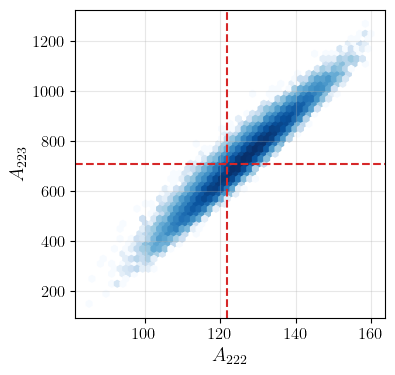

In [37]:
ni = 2
nj = 3

x = A_samples[:, ni]
y = A_samples[:, nj]

fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(alpha=0.3)

hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, bins='log')

ax.axvline(np.abs(best_fit['C'][ni]), color='C3', linestyle='--')
ax.axhline(np.abs(best_fit['C'][nj]), color='C3', linestyle='--')

ax.set_xlabel(f'$A_{{22{ni}}}$')
ax.set_ylabel(f'$A_{{22{nj}}}$')

# fig.savefig('figures/presentation/correlation_1.png', dpi=300, bbox_inches='tight')

(0.0, 29770.697038237133)

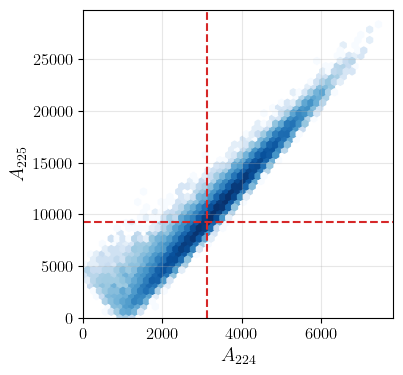

In [39]:
ni = 4
nj = 5

x = A_samples[:, ni]
y = A_samples[:, nj]

fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(alpha=0.3)

hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, bins='log')

ax.axvline(np.abs(best_fit['C'][ni]), color='C3', linestyle='--')
ax.axhline(np.abs(best_fit['C'][nj]), color='C3', linestyle='--')

ax.set_xlabel(f'$A_{{22{ni}}}$')
ax.set_ylabel(f'$A_{{22{nj}}}$')

ax.set_xlim(0)
ax.set_ylim(0)

# fig.savefig('figures/presentation/correlation_2.png', dpi=300, bbox_inches='tight')

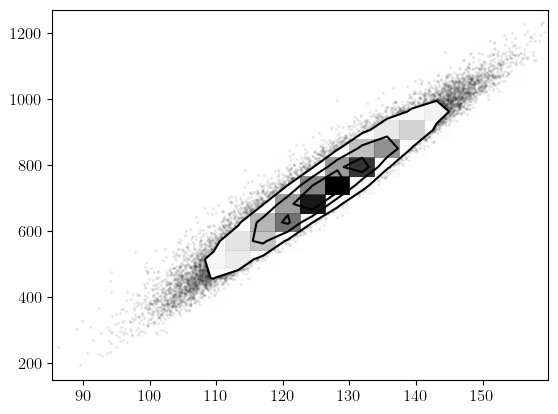

In [38]:
corner.hist2d(x, y)

(0.0, 76217.55976268546)

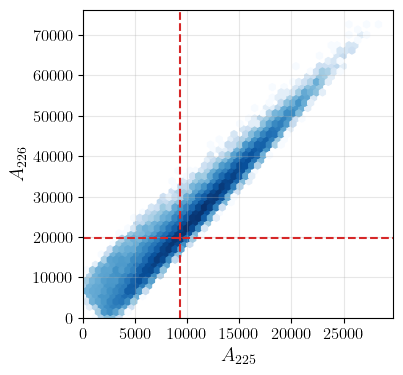

In [39]:
ni = 5
nj = 6

x = A_samples[:, ni]
y = A_samples[:, nj]

fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(alpha=0.3)

hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, bins='log')

ax.axvline(np.abs(best_fit['C'][ni]), color='C3', linestyle='--')
ax.axhline(np.abs(best_fit['C'][nj]), color='C3', linestyle='--')

ax.set_xlabel(f'$A_{{22{ni}}}$')
ax.set_ylabel(f'$A_{{22{nj}}}$')

ax.set_xlim(0)
ax.set_ylim(0)

# fig.savefig('figures/presentation/correlation_3.png', dpi=300, bbox_inches='tight')

In [40]:
len(sim.times[np.logical_and(sim.times>t0_M[f"{1}"][N], sim.times<70)])

967

In [41]:
t0_M.keys()

Index(['1', '2', '3', '4', '5', '6', '7', '10', '11', '12'], dtype='object')

In [ ]:
A_dict = {}
phi_dict = {}

IDs = t0_M.keys()

N = 11
modes = [(2, 2, n, 1) for n in range(N+1)]

for ID in IDs:

    ID = int(ID)

    try:
    # load data
        sim_info = utils.load_cce_data(ID)
        sim = sim_info['sim']
        chif = sim.chif_mag
        Mf = sim.Mf

    # perform LS fit
        best_fit = qnmfits.ringdown_fit(
        sim.times,
        sim.h[2,2],
        modes=modes+[(3,2,0,1)],
        Mf=Mf,
        chif=chif,
        t0=t0_M[f"{ID}"][N],
        t0_method='closest'
    )
        A320 = np.abs(best_fit['C'])[-1]
        omega = best_fit['frequencies'][:-1]
        
        data = {
            'plus': np.real(sim.h[2,2]),
            'cross': -np.imag(sim.h[2,2])}
            


    # perform analytic bayesian fit
        samples, A_samples, phi_samples = analytic_fit.sample(
        times=sim.times,
        data=data,
        # sigma=A320_of_t,
        sigma=A320*np.ones_like(sim.times),
        qnm_omegas=omega,
        t0=t0_M[f"{ID}"][N],
        t0_method='closest',
        T=70,
        reweight=False,
        # n_samples=2000000,
        )



        A_dict[ID] = A_samples
        phi_dict[ID] = phi_samples
        # unwrapped_phi_samples = phi_samples.copy()
        # for i in range(unwrapped_phi_samples.shape[1]):
        #     unwrapped_phi_samples[:,i] = analytic_fit.unwrap(unwrapped_phi_samples[:,i])


        # shift = unwrapped_phi_samples[0]-phi_samples[0] 
        # print(shift) # check that these are the same samples just shifted (all values should be multiples of 2pi)
        # phi_dict[ID] = unwrapped_phi_samples
        


In [ ]:
A_dict = {}
phi_dict = {}
samples_dict = {}

ID = 4

N = 4


for N in range(1,12):
    modes = [(2, 2, n, 1) for n in range(N+1)]




# load data
    sim_info = utils.load_cce_data(ID)
    sim = sim_info['sim']
    chif = sim.chif_mag
    Mf = sim.Mf

# perform LS fit
    best_fit = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    modes=modes+[(3,2,0,1)],
    Mf=Mf,
    chif=chif,
    t0=t0_M[f"{ID}"][N],
    t0_method='closest'
)
    A320 = np.abs(best_fit['C'])[-1]
    omega = best_fit['frequencies'][:-1]
    
    data = {
        'plus': np.real(sim.h[2,2]),
        'cross': -np.imag(sim.h[2,2])}
        


# perform analytic bayesian fit
    samples, A_samples, phi_samples = analytic_fit.sample(
    times=sim.times,
    data=data,
    # sigma=A320_of_t,
    sigma=A320*np.ones_like(sim.times),
    qnm_omegas=omega,
    t0=t0_M[f"{ID}"][N],
    t0_method='closest',
    T=70,
    reweight=False,
    # n_samples=2000000,
    )



    A_dict[N] = A_samples
    phi_dict[N] = phi_samples
    samples_dict[N] = samples
    # unwrapped_phi_samples = phi_samples.copy()
    # for i in range(unwrapped_phi_samples.shape[1]):
    #     unwrapped_phi_samples[:,i] = analytic_fit.unwrap(unwrapped_phi_samples[:,i])


    # shift = unwrapped_phi_samples[0]-phi_samples[0] 
    # print(shift) # check that these are the same samples just shifted (all values should be multiples of 2pi)
    # phi_dict[ID] = unwrapped_phi_samples
    


 

In [51]:
pd.DataFrame(A_samples)

0          1           2           3            4             5   \
0      1.443921  19.897809  159.389599  966.608355  5216.347671  12522.413669   
1      1.447346  19.900354  156.491149  914.943251  4645.450191  10268.259150   
2      1.445426  19.843426  159.678268  985.366126  5389.967118  12672.861076   
3      1.447713  19.934729  157.915458  929.816295  4722.050853  10474.405202   
4      1.446611  19.966105  159.431791  954.570565  5033.379476  11705.881357   
...         ...        ...         ...         ...          ...           ...   
49995  1.444930  19.786283  156.766435  952.627930  5244.420982  12820.109659   
49996  1.443545  19.711209  155.349838  932.774072  5017.121476  12014.128791   
49997  1.446202  19.755110  153.307181  890.243795  4618.731626  11010.223176   
49998  1.446386  20.067980  160.813399  957.502279  4931.356781  10863.218301   
49999  1.446904  19.864466  155.263467  891.374702  4391.813687   9448.081487   

                 6             7             8             9            10  \
0      18757.417995  18781.091435  16878.220127  12092.731933  6541.513238   
1      14913.165670  13719.263493  10413.015098   5424.847467  1932.908806   
2      19478.274265  19396.730905  16033.453481   9395.500955  4031.222735   
3      13988.487694  10229.527876   4347.659346   4970.965352  5911.263563   
4      17275.324325  16042.486352  12113.806811   6911.429080  4102.208757   
...             ...           ...           ...           ...          ...   
49995  19793.127742  20887.951024  19509.100854  13674.786690  6580.122400   
49996  17864.720367  17626.734477  15243.226769  10126.817566  4997.144564   
49997  15759.254490  15638.830056  15360.125753  13003.466655  8128.730739   
49998  16850.581182  17958.954199  18089.772028  14939.168979  8962.077587   
49999  12657.276281   9689.715099   4644.543596   1509.707773  2912.154774   

                11          12  
0      2318.129405  384.726429  
1       674.621687  147.480407  
2      1458.170960  293.536036  
3      3050.303535  618.019931  
4      1980.024661  414.225832  
...            ...         ...  
49995  1927.269984  258.865775  
49996  1662.155616  268.229896  
49997  3102.441468  527.781457  
49998  3315.700558  554.868948  
49999  1668.529369  348.179552  

[50000 rows x 13 columns]

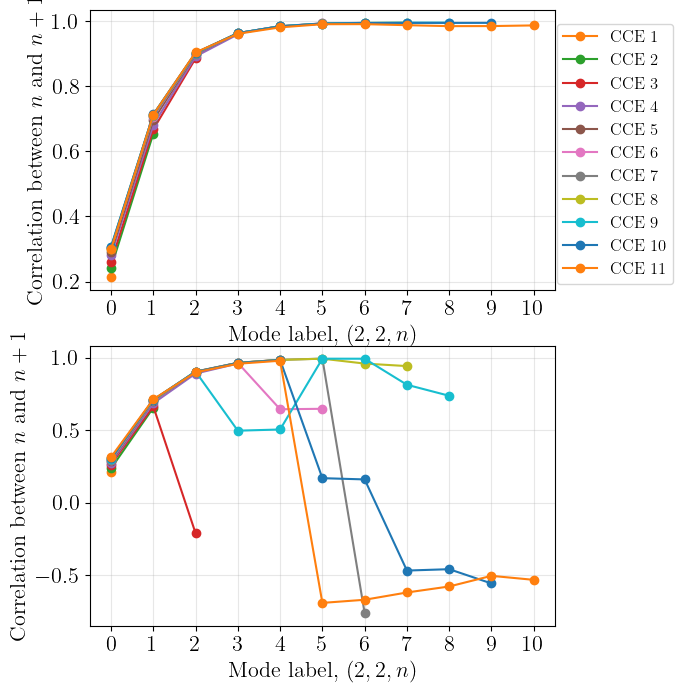

In [57]:
# Take the diagonal below the main diagonal of the correlation matrix

fig, ax = plt.subplots(nrows = 2, figsize=(6, 8))


ax[0].grid(alpha=0.3)

for ID, A_samples in A_dict.items():
    corr_matrix = np.corrcoef(A_samples.T)
    corrs = np.diag(corr_matrix, k=-1)
    ax[0].plot(corrs, marker='o', linestyle='-', color=f'C{ID}', label = f'CCE {ID}')


ax[0].set_xticks(range(len(corrs)))
ax[0].tick_params(axis='x', labelsize=16)
ax[0].tick_params(axis='y', labelsize=16)

# ax.set_ylim(0.38, 1.01)

ax[0].set_xlabel('Mode label, $(2,2,n)$', fontsize=16)
ax[0].set_ylabel('Correlation between $n$ and $n+1$', fontsize=16)




ax[1].grid(alpha=0.3)

for ID, phi_samples in phi_dict.items():
    corr_matrix = np.corrcoef(phi_samples.T)
    corrs = np.diag(corr_matrix, k=-1)
    ax[1].plot(corrs, marker='o', linestyle='-', color=f'C{ID}')


ax[1].set_xticks(range(len(corrs)))
ax[1].tick_params(axis='x', labelsize=16)
ax[1].tick_params(axis='y', labelsize=16)

# ax.set_ylim(0.38, 1.01)

ax[1].set_xlabel('Mode label, $(2,2,n)$', fontsize=16)
ax[1].set_ylabel('Correlation between $n$ and $n+1$', fontsize=16)

fig.legend(loc='center',bbox_to_anchor=[1, 0.7])


# fig.savefig('figures/presentation/correlation_diagonal.png', dpi=300, bbox_inches='tight')

In [45]:


# load data
sim_info = utils.load_cce_data(4)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

# perform LS fit
best_fit = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    modes=modes,
    Mf=Mf,
    chif=chif,
    t0=t0,
    t0_method='closest'
    )

A320 = np.abs(best_fit['C'])[-1]
omega = best_fit['frequencies'][:-1]

# perform analytic bayesian fit
samples, A_samples, phi_samples = analytic_fit.sample(
times=sim.times,
data=data,
# sigma=A320_of_t,
sigma=A320*np.ones_like(sim.times),
    qnm_omegas=omega,
    t0=t0,
    t0_method='closest',
    T=70,
    reweight=False,
    # n_samples=2000000,
    )


unwrapped_phi_samples = phi_samples.copy()
for i in range(unwrapped_phi_samples.shape[1]):
    unwrapped_phi_samples[:,i] = analytic_fit.unwrap(unwrapped_phi_samples[:,i])






In [46]:
# check that we are in fact recovering correct amplitudes

ID = 1
N = 12
sim_info, C, omega = utils.injection(ID, N, additional_modes=[(3,2,0,1)], returnC=True)

A320 = np.abs(C)[-1]

# load sim parameters
sim_info = utils.load_cce_data(ID)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

data = {'plus': np.real(sim.h[2,2]),
        'cross': -np.imag(sim.h[2,2]),
        }

downsampled_times = sim.times[::5]

downsampled_data = {'plus':np.interp(downsampled_times, sim.times, data['plus']),
                    'cross':np.interp(downsampled_times, sim.times, data['cross'])}


# perform analytic bayesian fit
samples, A_samples, phi_samples = analytic_fit.sample(
    times=downsampled_times,
    data=downsampled_data,
    # sigma=A320_of_t,
    sigma=1*A320*np.ones_like(sim.times),
    qnm_omegas=omega[:-1],
    t0=t0_M[f"{ID}"][N],
    t0_method='closest',
    T=70,
    reweight=False,
    # n_samples=2000000,
    )

# unwrapped_phi_samples = phi_samples.copy()
# for i in range(unwrapped_phi_samples.shape[1]):
#     unwrapped_phi_samples[:,i] = analytic_fit.unwrap(unwrapped_phi_samples[:,i])


# shift = unwrapped_phi_samples[0]-phi_samples[0] 
# print(shift) # check that these are the same samples just shifted (all values should be multiples of 2pi)



Calculating for n = 0
Calculating for n = 1
Calculating for n = 2
Calculating for n = 3
Calculating for n = 4
Calculating for n = 5
Calculating for n = 6
Calculating for n = 7
Calculating for n = 8
Calculating for n = 9
Calculating for n = 10
Calculating for n = 11
Calculating for n = 12


In [ ]:
   except Exception as e:
        print(e)
        print(f"Linear algebra error: CCE {ID}. Trying downsample")
        try:
            # downsample by a factor of 5
            downsampled_times = sim.times[::5]

            downsampled_data = {'plus':np.interp(downsampled_times, sim.times, data['plus']),
                        'cross':np.interp(downsampled_times, sim.times, data['cross'])}
            # perform analytic bayesian fit
            samples, A_samples, phi_samples = analytic_fit.sample(
                times=sim.times,
                data=data,
                # sigma=A320_of_t,
                sigma=A320*np.ones_like(sim.times),
                qnm_omegas=omega,
                t0=t0_M[f"{ID}"][N],
                t0_method='closest',
                T=70,
                reweight=False,
                # n_samples=2000000,
                )



            A_dict[ID] = A_samples
            phi_dict[ID] = phi_samples
            samples_dict[N] = samples
            
        except Exception:
            print(f"Linear algebra error: CCE {ID}.")
        
        
